In [1]:
from sklearn.datasets import fetch_openml

# fetch_openml returns a Bunch object, which is a dictionary-like object with keys and values
# as_frame=False means it will not convert the data into a DataFrame
mnist = fetch_openml('mnist_784', as_frame=False)

In [2]:
X, y = mnist.data, mnist.target
print(X, y)
print(X.shape, y.shape)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] ['5' '0' '4' ... '4' '5' '6']
(70000, 784) (70000,)


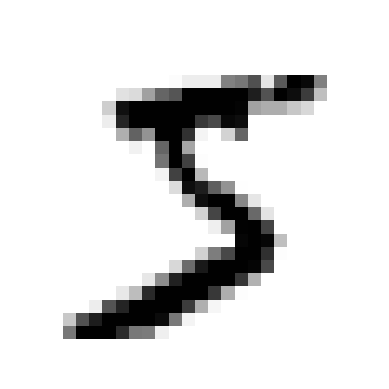

this image is a 5


In [3]:
import matplotlib.pyplot as plt

def plot_image(image_data):
    # X has shape (784,) because each image is has a width and height of 28 pixels
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    # plt.axes("off") removes the axes for better visualization
    plt.axis("off")

some_digit = X[0]
plot_image(some_digit)
plt.show()

print(f"this image is a {y[0]}")

In [34]:
# this proportion has been predecided in the dataset
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [5]:
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

In [8]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

,loss,'hinge'
,penalty,'l2'
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,1000
,tol,0.001
,shuffle,True
,verbose,0
,epsilon,0.1
,n_jobs,None


In [9]:
sgd_clf.predict([some_digit])

array([ True])

In [10]:
from sklearn.model_selection import cross_val_score
# cross_val_score trains the model on one fold and then tests it on the other folds, and keeps on repeating this
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [ ]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
# any() returns True if at least one element of the array is True, otherwise False
# as the most frequent output here is Flase we see False for all predictions
print(any(dummy_clf.predict(X_train)))

False


In [19]:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90965, 0.90965, 0.90965])

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

# StratifiedKFold creates folds that have the same proportion of samples for each target class as the whole dataset
skfold = StratifiedKFold(n_splits=3)

# skfold.split() returns indices for training and testing sets for each fold
for train_index, test_index in skfold.split(X_train, y_train):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(f"accuracy: {n_correct / len(y_test_fold)}")

accuracy: 0.96215
accuracy: 0.94995
accuracy: 0.9673


In [21]:
from sklearn.model_selection import cross_val_predict

predictions = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [22]:
from sklearn.metrics import confusion_matrix

cnn = confusion_matrix(y_train_5, predictions)
cnn

array([[53892,   687],
       [ 1891,  3530]])

In [24]:
y_train_5_perfect_prediction = y_train_5
cnn_perfect = confusion_matrix(y_train_5_perfect_prediction, y_train_5)
cnn_perfect

array([[54579,     0],
       [    0,  5421]])

In [ ]:
from sklearn.metrics import precision_score, recall_score

# precision is the ratio of true positives to the total predicted positives
# When it predicts 5s it is correct 83.7% of the times
print(f"The precision score is: {precision_score(y_train_5, predictions)}")
# recall is the ratio of true positives to the total actual positives
# It classifies 65.1% of the 5s correctly
print(f"The recall score is: {recall_score(y_train_5, predictions)}")

The precision score is: 0.8370879772350012
The recall score is: 0.6511713705958311


In [26]:
from sklearn.metrics import f1_score

print(f"The f1_score of the model is: {f1_score(y_train_5, predictions)}")

The f1_score of the model is: 0.7325171197343847


In [ ]:
y_scores = sgd_clf.decision_function([some_digit])
# decision_function gives the distance of the instances from the decision boundary
y_scores

array([2164.22030239])

In [29]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [30]:
threshold = 3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

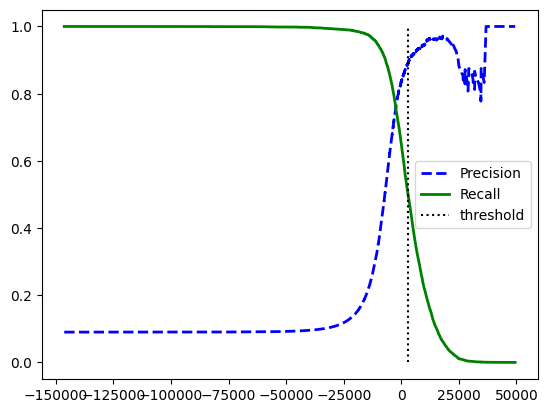

In [ ]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

# precisions[:-1] means “all except the last element” because precision_recall_curve returns arrays 
# where thresholds has one less element than precision/recall.
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2) 
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
# vlines means plot a vertical line
# 0, 1.0 is the range for y axis
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")
plt.legend()

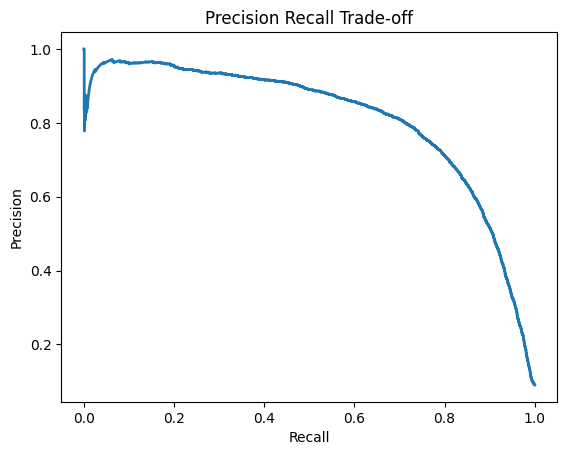

In [37]:
plt.plot(recalls, precisions, linewidth=2, label="Precision-Recall curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision Recall Trade-off")
plt.show()

In [39]:
idx_for_90_precision = (precisions > 0.9).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

np.float64(3370.0194991439557)

In [40]:
y_train_pred_90_precision = (y_scores > threshold_for_90_precision)
print(f"Precision for 90%: {precision_score(y_train_5, y_train_pred_90_precision)}")
print(f"Recall for 90%: {recall_score(y_train_5, y_train_pred_90_precision)}")

Precision for 90%: 0.9
Recall for 90%: 0.47980077476480354


In [41]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

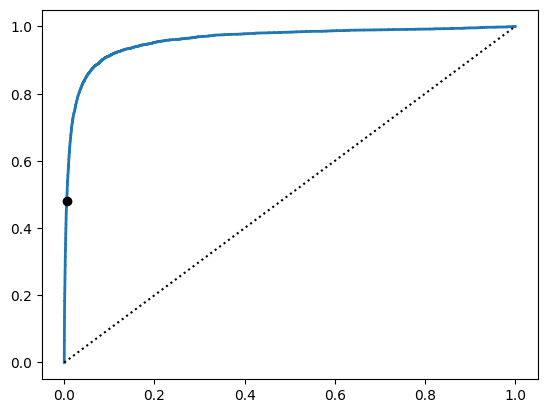

In [42]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax() 
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]
plt.plot(fpr, tpr, linewidth=2, label="ROC curve") 
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve") 
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")
plt.show()

In [43]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [44]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)

In [45]:
# predict_proba returns probabilities for each class
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")
y_probas_forest[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

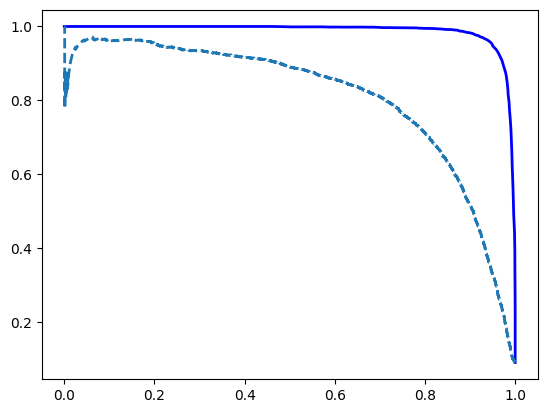

In [46]:
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)

plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2, label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD") 
plt.show()

In [50]:
y_train_pred_forest = y_probas_forest[:, 1] >= 0.5
print(f"The f1 score of the model is: {f1_score(y_train_pred_forest, y_train_5)}")
print(f"The rocu_auc_score of the model is: {roc_auc_score(y_train_pred_forest, y_train_5)}")

The f1 score of the model is: 0.9274509803921569
The rocu_auc_score of the model is: 0.9886167267647354


In [51]:
from sklearn.svm import SVC

svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000])

,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [52]:
svm_clf.predict([some_digit])

array(['5'], dtype=object)

In [53]:
some_digit_score = svm_clf.decision_function([some_digit])
some_digit_score

array([[ 3.79297828,  0.72949369,  6.06184129,  8.29800527, -0.29383983,
         9.30157597,  1.74723215,  2.77365456,  7.20601456,  4.82245092]])

In [54]:
class_id = some_digit_score.argmax()
class_id

np.int64(5)

In [ ]:
# Gives a list of all classes the classifier can predict
print(svm_clf.classes_)
svm_clf.classes_[class_id]

['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


'5'

In [57]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])

,estimator,SVC(random_state=42)
,n_jobs,None
,verbose,0
,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001


In [58]:
ovr_clf.predict([some_digit])

array(['5'], dtype='<U1')

In [59]:
len(ovr_clf.estimators_)

10

In [60]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array(['3'], dtype='<U1')

In [61]:
sgd_clf.decision_function([some_digit]).round(2)

array([[-31893.03, -34419.69,  -9530.64,   1823.73, -22320.15,  -1385.8 ,
        -26188.91, -16147.51,  -4604.35, -12050.77]])

In [62]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

In [14]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_test)
cross_val_score(sgd_clf, X_test_scaled, y_test, cv=3, scoring="accuracy")

array([0.86412717, 0.89708971, 0.89528953])

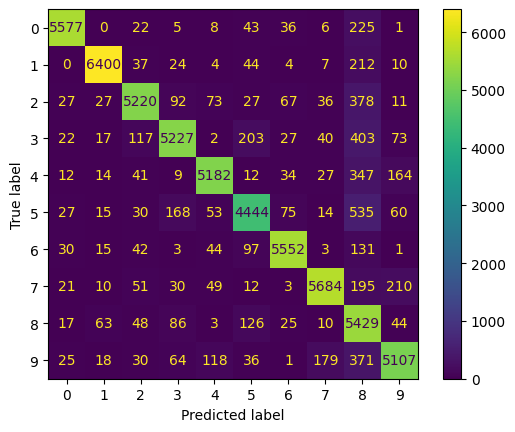

In [65]:
from sklearn.metrics import ConfusionMatrixDisplay

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
plt.show()

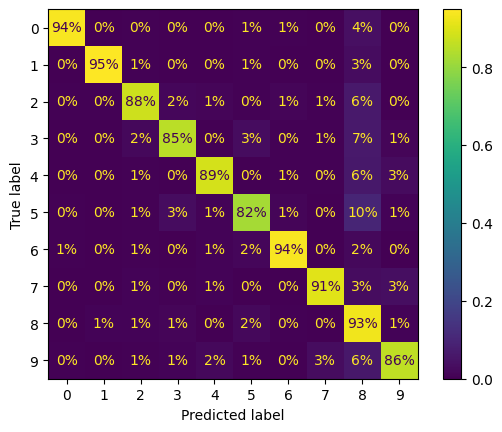

In [66]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, normalize="true", values_format=".0%")
plt.show()

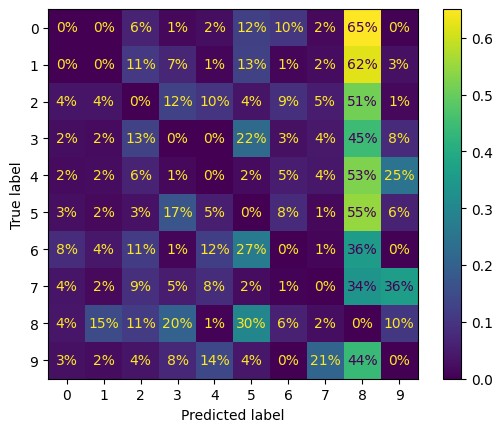

In [ ]:
sample_weight = (y_train_pred != y_train)
# normalize="true": each row (true class) is divided by the row sum, so values are percentages of the actual 
# class’s total. This tells you how often each class is classified correctly/incorrectly.
# sample_weight is used to give more weight to misclassifications, making them more important in the model.
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, sample_weight=sample_weight, normalize="true",
                                        values_format=".0%")
plt.show()

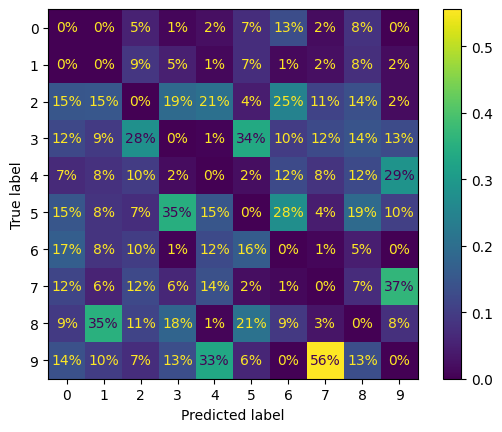

In [70]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, sample_weight=sample_weight, normalize="pred",
                                        values_format=".0%")
plt.show()

In [76]:
cl_a, cl_b = '3', '5'
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_images(X_aa, X_ab, X_ba, X_bb, img_shape=(28,28), max_per_cell=25):
    # Arrange them in the confusion matrix layout
    data_blocks = [
        [X_aa, X_ab],
        [X_ba, X_bb]
    ]
    titles = [
        ["True A / Pred A", "True A / Pred B"],
        ["True B / Pred A", "True B / Pred B"]
    ]
    
    fig, axes = plt.subplots(2, 2, figsize=(8, 8))

    for i in range(2):
        for j in range(2):
            images = data_blocks[i][j]
            # Limit number per cell
            images = images[:max_per_cell]
            
            if len(images) == 0:
                axes[i, j].axis("off")
                continue
            
            # Determine grid size for tiling
            n_cols = int(np.ceil(np.sqrt(len(images))))
            n_rows = int(np.ceil(len(images) / n_cols))
            
            # Create a blank canvas for the collage
            collage = np.ones((n_rows * img_shape[0], n_cols * img_shape[1])) * 255
            
            for idx, img in enumerate(images):
                row = idx // n_cols
                col = idx % n_cols
                collage[
                    row*img_shape[0] : (row+1)*img_shape[0],
                    col*img_shape[1] : (col+1)*img_shape[1]
                ] = img.reshape(img_shape)
            
            axes[i, j].imshow(collage, cmap="gray")
            axes[i, j].set_title(titles[i][j])
            axes[i, j].axis("off")
    
    plt.tight_layout()
    plt.show()


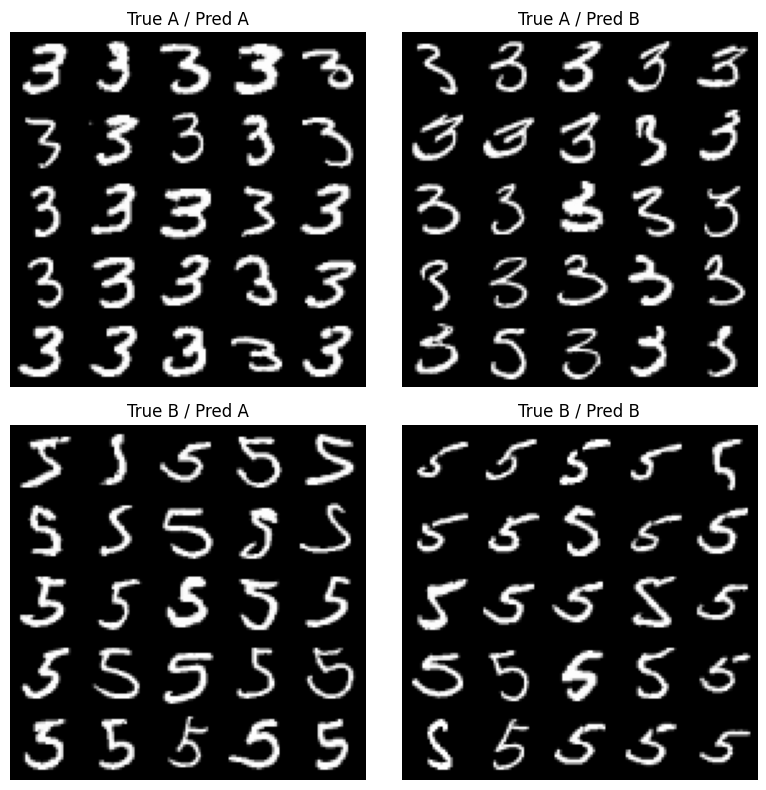

In [77]:
plot_confusion_images(X_aa, X_ab, X_ba, X_bb, img_shape=(28,28), max_per_cell=25)

In [79]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= '7')
y_train_odd = (y_train.astype(np.int8) % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [80]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [81]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)

f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.9764102655606048

In [83]:
from sklearn.multioutput import ClassifierChain

chain_clf = ClassifierChain(SVC(), cv=3, random_state=42)
chain_clf.fit(X_train[:2000], y_multilabel[:2000])

,estimator,SVC()
,order,None
,cv,3
,chain_method,'predict'
,random_state,42
,verbose,False
,base_estimator,'deprecated'
,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'


In [84]:
chain_clf.predict([some_digit])

array([[0., 1.]])

In [85]:
np.random.seed(42)
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

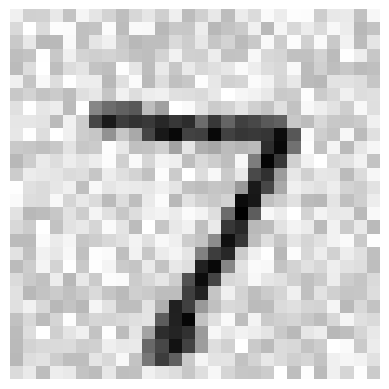

In [88]:
mod_digit = X_test_mod[0]
plot_image(mod_digit)

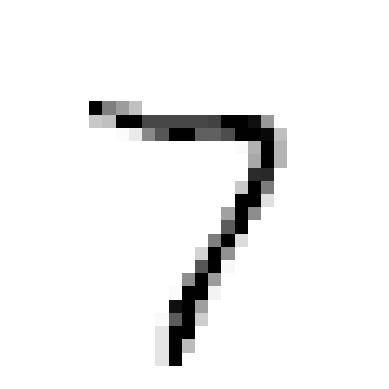

In [87]:
knn_clf = KNeighborsClassifier() 
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[0]]) 
plot_image(clean_digit) 
plt.show()

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()

param_grids = [
    {'weights': ['uniform', 'distance'], 'n_neighbors': [3, 4, 5, 6]}
]

grid_cv = GridSearchCV(knn_clf, param_grids, cv=3, verbose=2)
grid_cv.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END .....................n_neighbors=3, weights=uniform; total time=   6.8s
[CV] END .....................n_neighbors=3, weights=uniform; total time=   7.0s
[CV] END .....................n_neighbors=3, weights=uniform; total time=  10.9s
[CV] END ....................n_neighbors=3, weights=distance; total time=  14.0s
[CV] END ....................n_neighbors=3, weights=distance; total time=  14.1s
[CV] END ....................n_neighbors=3, weights=distance; total time=   7.2s
[CV] END .....................n_neighbors=4, weights=uniform; total time=   6.9s
[CV] END .....................n_neighbors=4, weights=uniform; total time=   6.3s
[CV] END .....................n_neighbors=4, weights=uniform; total time=   6.8s
[CV] END ....................n_neighbors=4, weights=distance; total time=   6.2s
[CV] END ....................n_neighbors=4, weights=distance; total time=   7.1s
[CV] END ....................n_neighbors=4, weigh

,estimator,KNeighborsClassifier()
,param_grid,"[{'n_neighbors': [3, 4, ...], 'weights': ['uniform', 'distance']}]"
,scoring,None
,n_jobs,None
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_neighbors,4


In [22]:
grid_cv.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [23]:
best_knn = grid_cv.best_estimator_

scores = cross_val_score(best_knn, X_test_scaled, y_test, cv=3, scoring="accuracy")

In [24]:
scores.mean()

np.float64(0.9022025177922711)

In [55]:
def left_shift_images(X, y):
    X_train_left_shifted = np.zeros((X.shape[0], X.shape[1], X.shape[2]))
    m, n, _ = X.shape

    for i in range(m):
        X_train_left_shifted[i, :, 1:] = X[i, :, :n-1]

    return X_train_left_shifted.reshape(-1, 784), y.copy()

def right_shift_images(X, y):
    X_train_right_shifted = np.zeros((X.shape[0], X.shape[1], X.shape[2]))
    m, n, _ = X.shape

    for i in range(m):
        X_train_right_shifted[i, :, :n-1] = X[i, :, 1:]
    
    return X_train_right_shifted.reshape(-1, 784), y.copy()

def up_shift_images(X, y):
    X_train_up_shifted = np.zeros((X.shape[0], X.shape[1], X.shape[2]))
    m, n, _ = X.shape

    for i in range(m):
        X_train_up_shifted[i, 1:, :] = X[i, :n-1, :]

    return X_train_up_shifted.reshape(-1, 784), y.copy()

def down_shift_images(X, y):
    X_train_down_shifted = np.zeros((X.shape[0], X.shape[1], X.shape[2]))
    m, n, _ = X.shape

    for i in range(m):
        X_train_down_shifted[i, :n-1, :] = X[i, 1:, :]

    return X_train_down_shifted.reshape(-1, 784), y.copy()

In [56]:
X_train_reshaped = X_train.reshape(-1, 28, 28)

X_train_left_shifted, y_train_left_shifted = left_shift_images(X_train_reshaped, y_train)
X_train_right_shifted, y_train_right_shifted = right_shift_images(X_train_reshaped, y_train)
X_train_up_shifted, y_train_up_shifted = up_shift_images(X_train_reshaped, y_train)
X_train_down_shifted, y_train_down_shifted = down_shift_images(X_train_reshaped, y_train)

In [57]:
X_train_new = np.concatenate([X_train, X_train_left_shifted, X_train_right_shifted, X_train_up_shifted, X_train_down_shifted])
y_train_new = np.concatenate([y_train, y_train_left_shifted, y_train_right_shifted, y_train_up_shifted, y_train_down_shifted])
print(X_train_new.shape, X_train.shape)

(300000, 784) (60000, 784)


In [58]:
scaler = StandardScaler()
X_train_new_scaled = scaler.fit_transform(X_train_new)

In [ ]:
knn_clf = KNeighborsClassifier()

param_grids = [
    {'weights': ['distance'], 'n_neighbors': [3, 4, 5]}
]

grid_cv = GridSearchCV(knn_clf, param_grids, cv=3, verbose=2)
grid_cv.fit(X_train_new_scaled, y_train_new)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] END ....................n_neighbors=3, weights=distance; total time= 2.5min
